# Embeddings

### Loading Libraries

In [1]:
# Operating Systems
import os
import shutil

# Data Manipuation
import pandas as pd

# SciPy
import scipy
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# BigQuery
from google.cloud import bigquery
from google.colab import auth

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow_hub import KerasLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# User Authentication
auth.authenticate_user()

# BigQuery Library
# !pip install --upgrade google-cloud-bigquery

In [3]:
project_id = 'core-catalyst-425922-v9'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# BigQuery Client Config
client = bigquery.Client(project=project_id)

### **Embedding Layer for Categorical Data**

In [4]:
# !head ./data/babyweight_sample.csv

In [5]:
df = pd.read_csv("/content/babyweight_sample.csv")
df.plurality.head(5)

0    Single(1)
1    Single(1)
2    Single(1)
3     Twins(2)
4    Single(1)
Name: plurality, dtype: object

In [6]:
df.plurality.unique()

array(['Single(1)', 'Twins(2)', 'Triplets(3)', 'Multiple(2+)',
       'Quadruplets(4)'], dtype=object)

In [7]:
CLASSES = {
    'Single(1)': 0,
    'Multiple(2+)': 1,
    'Twins(2)': 2,
    'Triplets(3)': 3,
    'Quadruplets(4)': 4,
    'Quintuplets(5)': 5
}
N_CLASSES = len(CLASSES)

In [8]:
plurality_class = [CLASSES[plurality] for plurality in df.plurality]

In [9]:
print(df.plurality[:5])

print(plurality_class[:5])

0    Single(1)
1    Single(1)
2    Single(1)
3     Twins(2)
4    Single(1)
Name: plurality, dtype: object
[0, 0, 0, 2, 0]


In [10]:
EMBED_DIM = 2

embedding_layer = layers.Embedding(input_dim=N_CLASSES,
                                   output_dim=EMBED_DIM)
embeds = embedding_layer(tf.constant(plurality_class))

In [11]:
embeds.shape

TensorShape([999, 2])

In [12]:
embeds[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.02651275, -0.04206783],
       [ 0.02651275, -0.04206783],
       [ 0.02651275, -0.04206783],
       [ 0.00842694,  0.01681883],
       [ 0.02651275, -0.04206783]], dtype=float32)>

### **Embedding Layers in Keras Model**

In [13]:
LOGDIR = "./text_models"

DATA_DIR = "./data"

In [14]:
DATASET_NAME = "/content/titles_full.csv"

TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)

COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

integerized_titles = tokenizer.texts_to_sequences(titles_df.title)

In [16]:
integerized_titles[:3]

[[6117, 560, 8577, 13948, 302, 13, 172],
 [11, 12, 2, 49, 7, 3838, 1322, 91, 4, 28, 482],
 [11, 12, 1501, 2812, 322, 5, 589, 7337, 5458, 78, 108, 1989, 17, 1139]]

In [17]:
VOCAB_SIZE = len(tokenizer.index_word)

VOCAB_SIZE

47271

In [18]:
DATASET_SIZE = tokenizer.document_count

DATASET_SIZE

96203

In [19]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)

MAX_LEN

26

### **Preprocess Data**

In [20]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,
                                     max_len,
                                     padding='post')
    return padded_sequences

In [21]:
sample_titles = create_sequences(["holy cash cow  batman - content is back",
                                 "close look at a flu outbreak upends some common wisdom"])
sample_titles

array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1030,   316,    23,     2,  3718,  7338, 13949,   214,   715,
         4581,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [22]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}

N_CLASSES = len(CLASSES)

In [23]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = utils.to_categorical(classes)
    return one_hots

#### **Setting Training & Validation Split**

In [24]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [25]:
sources_train.value_counts()

source
github        29175
techcrunch    24784
nytimes       23003
Name: count, dtype: int64

In [26]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)

X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [27]:
X_train[:3], Y_train[:3]

(array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   11,    12,     2,    49,     7,  3838,  1322,    91,     4,
            28,   482,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   11,    12,  1501,  2812,   322,     5,   589,  7337,  5458,
            78,   108,  1989,    17,  1139,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]],
       dtype=int32),
 array([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32))

### **Building a DNN**

In [28]:
def build_dnn_model(embed_dim):

    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE + 1,
                         embed_dim,
                         input_shape=[MAX_LEN]),
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [29]:
Y_train.shape

(76962, 3)

Epoch 1/100
257/257 [==============================] - 23s 82ms/step - loss: 1.0514 - accuracy: 0.4255 - val_loss: 0.9843 - val_accuracy: 0.5916
Epoch 2/100
257/257 [==============================] - 4s 17ms/step - loss: 0.8934 - accuracy: 0.6924 - val_loss: 0.8094 - val_accuracy: 0.7236
Epoch 3/100
257/257 [==============================] - 6s 22ms/step - loss: 0.7361 - accuracy: 0.7812 - val_loss: 0.6842 - val_accuracy: 0.7820
Epoch 4/100
257/257 [==============================] - 3s 10ms/step - loss: 0.6285 - accuracy: 0.8091 - val_loss: 0.5997 - val_accuracy: 0.8023
Epoch 5/100
257/257 [==============================] - 2s 7ms/step - loss: 0.5512 - accuracy: 0.8272 - val_loss: 0.5385 - val_accuracy: 0.8186
Epoch 6/100
257/257 [==============================] - 2s 6ms/step - loss: 0.4929 - accuracy: 0.8405 - val_loss: 0.4937 - val_accuracy: 0.8251
Epoch 7/100
257/257 [==============================] - 2s 7ms/step - loss: 0.4482 - accuracy: 0.8510 - val_loss: 0.4605 - val_accuracy: 0

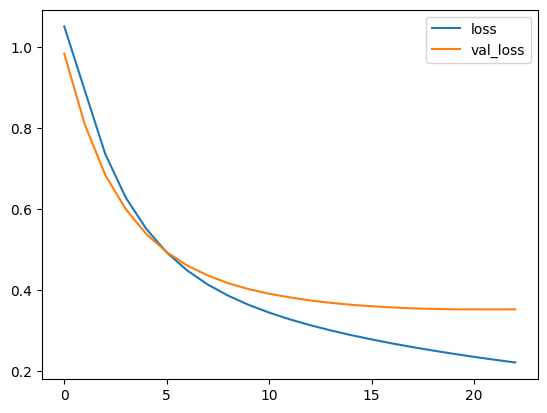

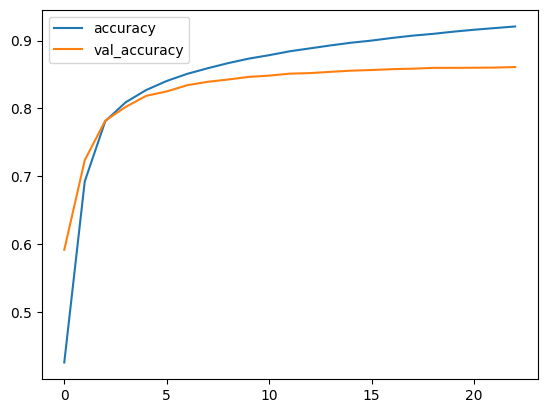

In [30]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

### **Transfer Learning with Pre-Trained Embedding**

In [31]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    handle=NNLM,
    output_shape=[50],
    input_shape=[],
    dtype=tf.string,
    trainable=True)

In [32]:
nnlm_module(tf.constant(["holy cash cow  batman - content is back",
                         "close look at a flu outbreak upends some common wisdom"]))

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.0958989 , -0.34283403, -0.0492865 , -0.09070478,  0.15877679,
        -0.21235444,  0.28213888, -0.02812295, -0.07855891, -0.13102815,
         0.11162009,  0.00899507,  0.01711924,  0.3225362 , -0.13289748,
         0.11935383,  0.04386025,  0.06534778,  0.2200468 , -0.13539286,
        -0.0296053 , -0.06080014,  0.12862371,  0.23304918, -0.04424818,
         0.07436227, -0.1898077 , -0.13270935,  0.21959059,  0.10597934,
         0.03580458,  0.14275002, -0.06624421, -0.3247055 ,  0.04618761,
        -0.11603004,  0.06651007,  0.10887001, -0.05413235, -0.07126983,
         0.02225055,  0.2645486 , -0.04697315,  0.0672911 , -0.14438024,
         0.06355232, -0.05749882, -0.04587578,  0.23790349,  0.258379  ],
       [ 0.11347695, -0.04064287,  0.1053718 , -0.23681389, -0.08755026,
        -0.29770336, -0.00098698,  0.23123494, -0.05596383,  0.04687293,
         0.07230621, -0.10018747,  0.17597003, -0.04471373, -0.16409421,
 

In [33]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)

X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [34]:
X_train[:3]

array(['holy cash cow  batman - content is back',
       'show hn  a simple and configurable deployment tool for github projects',
       'show hn  neural turing machine in pure numpy. implements all 5 tasks from paper'],
      dtype=object)

### **Building DNN Model using TF-Hub Embedding Layer**

In [35]:
def build_hub_model():
    model = models.Sequential([
        KerasLayer(handle=NNLM,
                   output_shape=[50],
                   input_shape=[],
                   dtype=tf.string,
                   trainable=True),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Epoch 1/100
257/257 [==============================] - 33s 120ms/step - loss: 0.7275 - accuracy: 0.7194 - val_loss: 0.4921 - val_accuracy: 0.8164
Epoch 2/100
257/257 [==============================] - 8s 30ms/step - loss: 0.4068 - accuracy: 0.8486 - val_loss: 0.4006 - val_accuracy: 0.8390
Epoch 3/100
257/257 [==============================] - 8s 30ms/step - loss: 0.3221 - accuracy: 0.8794 - val_loss: 0.3816 - val_accuracy: 0.8437
Epoch 4/100
257/257 [==============================] - 5s 20ms/step - loss: 0.2752 - accuracy: 0.8982 - val_loss: 0.3820 - val_accuracy: 0.8460
Epoch 5/100
257/257 [==============================] - 6s 22ms/step - loss: 0.2428 - accuracy: 0.9115 - val_loss: 0.3926 - val_accuracy: 0.8427
Epoch 6/100
257/257 [==============================] - 5s 19ms/step - loss: 0.2187 - accuracy: 0.9208 - val_loss: 0.4085 - val_accuracy: 0.8402
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape     

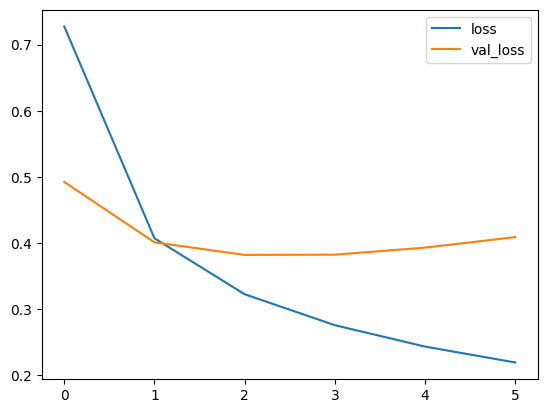

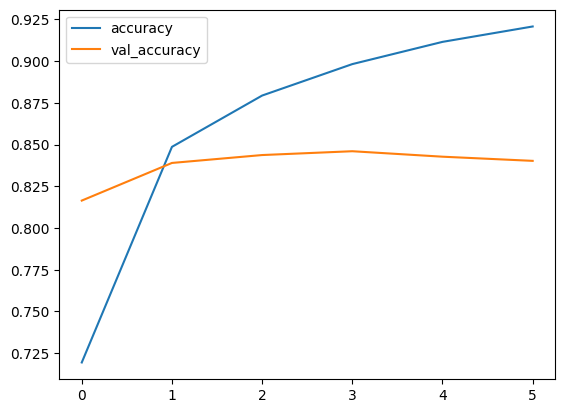

In [36]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'hub')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 3

hub_model = build_hub_model()

hub_history = hub_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(hub_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(hub_history.history)[['accuracy', 'val_accuracy']].plot()

hub_model.summary()